In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import psycopg2 as pg

In [2]:
class Database():
    def __init__(self):
        self.output = None
        
    def connect(self):
        return pg.connect(host="localhost", port="5432", database="bi", user="postgres", password="postgres")

    def execute(self, query, fetch=True):
            try:
                with self.connect() as conn:
                    with conn.cursor() as cursor:
                        cursor.execute(query)
                        column_names = [info[0] for info in cursor.description]
                        value = (cursor.fetchall() if fetch else True)
                conn.close()
            except (Exception, pg.DatabaseError) as error:
                print(f"Error: {error}")
                self.output = None
                return None if fetch else False
            finally:
                conn.close()
            self.output = pd.DataFrame(value, columns=column_names)
            return self.output

db = Database()

# Database data selection

In [3]:
query = '''
    SELECT  facts_rating.id, facts_rating.rating,
            category.name as "category", 
            region.name as "region", 
            wine.name as "wine_name", wine.designation, wine.varietal, wine.alcohol, wine.price,
            winery.name as "winery",
            reviewer.reviewer
    FROM facts_rating 
    JOIN category ON facts_rating.category_id = category.id 
    JOIN region ON facts_rating.region_id = region.id
    JOIN wine ON facts_rating.wine_id = wine.id
    JOIN winery ON facts_rating.winery_id = winery.id
    JOIN reviewer ON facts_rating.reviewer_id = reviewer.id
    order by id;
'''
df = db.execute(query)
df

,id,rating,category,region,wine_name,designation,varietal,alcohol,price,winery,reviewer
0,1,87,Red,"Paso Robles, Central Coast, California, US",J. Lohr 2000 Hilltop Vineyard Cabernet Sauvign...,Hilltop Vineyard,Cabernet Sauvignon,0.0,32,J. Lohr,
1,2,85,Red,"Vista Flores, Mendoza Province, Argentina",Antucura 2010 Pinot Noir (Vista Flores),,Pinot Noir,15.0,17,Antucura,Michael Schachner
2,3,90,Red,"Douro, Portugal",Quinta do Portal 1999 Quinta do Portal Reserva...,Quinta do Portal Reserva,"Red Blends, Red Blends",0.0,0,Quinta do Portal,Roger Voss
3,4,86,Red,"Toscana, Tuscany, Italy",Tenuta di Ghizzano 2006 Il Ghizzano Red (Toscana),Il Ghizzano,"Red Blends, Red Blends",13.5,18,Tenuta di Ghizzano,
4,5,85,White,"Campania, Southern Italy, Italy",Tenuta San Francesco 2007 Tramonti White (Camp...,Tramonti,White Blend,13.5,21,Tenuta San Francesco,
...,...,...,...,...,...,...,...,...,...,...,...
323116,323233,87,Rose,"Paso Robles, Central Coast, California, US",Maddalena 2017 Rosé (Paso Robles),,Rosé,12.5,18,Maddalena,Matt Kettmann
323117,323234,87,White,"Vernaccia di San Gimignano, Tuscany, Italy",Toscolo 2015 Vernaccia di San Gimignano,,"Vernaccia, Italian White",12.5,11,Toscolo,Kerin O’Keefe
323118,323235,90,White,"Alsace, Alsace, France",Domaine G. Metz 2017 Pinot Blanc (Alsace),,Pinot Blanc,13.0,20,Domaine G. Metz,Anne Krebiehl MW
323119,323236,87,Red,"Idaho, Idaho, US",Huston 2019 Chicken Dinner Red (Idaho),Chicken Dinner,"Red Blends, Red Blends",14.3,18,Huston,Sean P. Sullivan


In [4]:
columns_by_datatypes = df.columns.to_series().groupby(df.dtypes).groups
data_dict = eval(str(columns_by_datatypes).replace("{", "{'").replace("], ","], '").replace(": [", "': ["))
data_dict

{'int64': ['id', 'rating', 'price'],
 'float64': ['alcohol'],
 'object': ['category',
  'region',
  'wine_name',
  'designation',
  'varietal',
  'winery',
  'reviewer']}

## Data Info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323121 entries, 0 to 323120
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           323121 non-null  int64  
 1   rating       323121 non-null  int64  
 2   category     323121 non-null  object 
 3   region       323121 non-null  object 
 4   wine_name    323121 non-null  object 
 5   designation  323121 non-null  object 
 6   varietal     323121 non-null  object 
 7   alcohol      323121 non-null  float64
 8   price        323121 non-null  int64  
 9   winery       323121 non-null  object 
 10  reviewer     323121 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 27.1+ MB


# Data Description

In [6]:
def describe_feature(column):
    print(f"NaN: {df[column].isnull().sum()}", end="\n\n")
    print(df[column].value_counts(), end="\n\n")

## Numerical Data Description

In [7]:
df.describe()

,id,rating,alcohol,price
count,323121.000000,323121.000000,323121.000000,323121.000000
mean,161610.926767,88.584982,12.043330,33.065966
std,93309.814398,3.186550,24.581648,70.488421
min,1.000000,80.000000,0.000000,0.000000
25%,80803.000000,86.000000,12.500000,15.000000
50%,161612.000000,88.000000,13.500000,24.000000
75%,242417.000000,91.000000,14.200000,40.000000
max,323237.000000,100.000000,8333.000000,8500.000000


In [8]:
for column in data_dict["int64"] + data_dict["float64"]:
    print(f"### Feature: {column} ###\n")
    describe_feature(column)

### Feature: id ###

NaN: 0

1         1
215478    1
215485    1
215484    1
215483    1
         ..
107738    1
107737    1
107736    1
107735    1
323237    1
Name: id, Length: 323121, dtype: int64

### Feature: rating ###

NaN: 0

88     41249
90     39671
87     38656
89     29952
91     28692
86     28288
92     24590
85     21579
93     17473
84     16103
94     10540
83      8746
82      5377
95      5087
96      2239
81      2040
80      1212
97      1031
98       400
99       118
100       78
Name: rating, dtype: int64

### Feature: price ###

NaN: 0

0       31167
20      16366
15      14440
25      14022
30      12176
        ...  
1750        1
5999        1
589         1
367         1
897         1
Name: price, Length: 540, dtype: int64

### Feature: alcohol ###

NaN: 0

13.50      45232
0.00       40991
13.00      38377
14.50      33369
14.00      29938
           ...  
15.57          1
225.00         1
17.30          1
8333.00        1
2016.00        1
Name: alcohol, Len

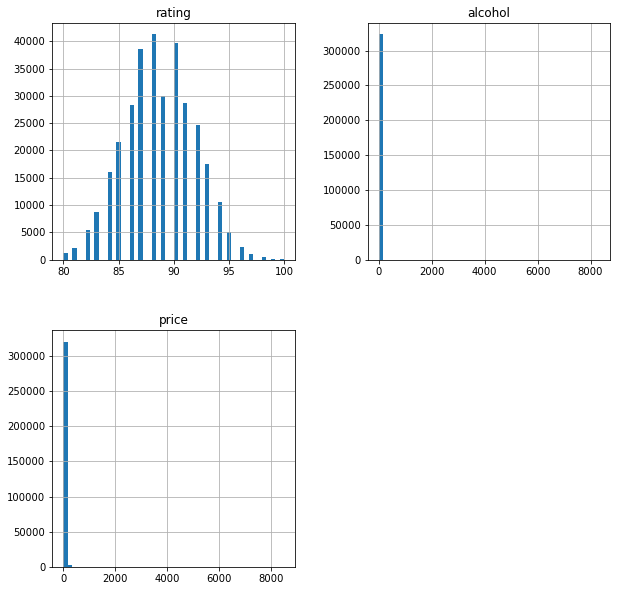

In [9]:
df[df.columns[1:]].hist(bins=50, figsize=(10,10));

## String Categorical Data description 

In [10]:
import matplotlib.pyplot as plt

In [11]:
for column in data_dict["object"]:
    print(f"### Feature: {column} ###\n")
    df[column] = df[column].apply(lambda entry: np.nan if entry == "" else entry)
    describe_feature(column)

### Feature: category ###

NaN: 0

Red            194309
White           95402
Sparkling       14933
Rose            11666
Dessert          4328
Port/Sherry      2257
Fortified         226
Name: category, dtype: int64

### Feature: region ###

NaN: 2607

Napa Valley, Napa, California, US                             11477
Columbia Valley (WA), Columbia Valley, Washington, US          9145
California, California Other, California, US                   7406
Russian River Valley, Sonoma, California, US                   7160
Paso Robles, Central Coast, California, US                     6101
                                                              ...  
Vino de la Tierra Ribera del Jiloca, Northern Spain, Spain        1
Deutscher Tafelwein Rhein, Germany                                1
Rosso di Cerignola, Southern Italy, Italy                         1
Barkan, Israel                                                    1
Delia Nivolelli, Sicily & Sardinia, Italy                        

In [12]:
data_dict

{'int64': ['id', 'rating', 'price'],
 'float64': ['alcohol'],
 'object': ['category',
  'region',
  'wine_name',
  'designation',
  'varietal',
  'winery',
  'reviewer']}

# Feature Engineering Plan

In terms of feature engineering:
- (**id**: Dropped)
- **rating**: Unchanged
- **category**: One-hot Encoded
- **region**: Mapped into lat, lng coordinates, through Nominatim API. If not able to find, map to (lat, lng) = (-200, -200), since it is out of earth bounds
- **wine_name**: Wine age will be extracted from the string. If not possible, the age will be 0. The interval of valid numbers is from 1700 to 2022 (ages 322 to 0)
- **designation**: Binning - The designations that have more that 30 entries, will have is own bin, all the others will be mapped to "Other" and then One-hot Encoded
- **varietal**: Binning - The varietals that have more that 30 entries, will have is own bin, all the others will be mapped to "Other" and then One-hot Encoded
- **alcohol**: Unbounded values (less than 0 or greater than 100) will be bounded to [0.0, 100.0]
- **price**: Unchanged
- **winery**: Binning - The wineries that have more that 30 entries, will have is own bin, all the others will be mapped to "Other" and then One-hot Encoded
- **reviewer**: Binning - The wineries that have more that 30 entries, will have is own bin, all the others will be mapped to "Other" and then One-hot Encoded


In [13]:
def binning(df, column, n=30):
    counts = df[column].value_counts(dropna=False)
    for i, value in enumerate(df[[column]].values):
        if not (counts[value[0]] >= n) or value[0] is np.nan:
            df.at[i, column] = np.nan
    return df[column]

def get_age(entry):
    current_year = datetime.date.today().year
    words = entry.split(" ")
    for word in words:
        try:
            value = int(word)
            if 1700 <= value <= current_year:
                return current_year - value
        except ValueError:
            pass
    return 0

def bound(entry):
    return max(min(entry, 100), 0)

In [14]:
DATAPATH = os.path.abspath('') + "/../../data/"

binning_cols = ["designation", "varietal", "winery", "reviewer"]
bins_min = [30, 30, 100, 0]
ohe_cols = ["category"] + binning_cols

# Get coordinates from region
coords_df = pd.read_csv(DATAPATH + "coords.csv")
df = pd.merge(df, coords_df, on="region")

# Get wine age
df["age"] = df["wine_name"].apply(get_age)

# Bound alcohol values
df["alcohol"] = df["alcohol"].apply(bound)

# Binning
for bc, n in zip(binning_cols, bins_min):
    binning(df, bc, n=n)

df = df.dropna()

# Dropping vars
df = df.drop(["id", "region", "wine_name"], axis=1)

# One-Hot Encoding
df = pd.get_dummies(df, columns=ohe_cols)

In [15]:
# NaN sum
df.isnull().sum().sum()

0

In [16]:
df

,rating,alcohol,price,lat,lng,age,category_Dessert,category_Fortified,category_Port/Sherry,category_Red,...,reviewer_Kerin O’Keefe,reviewer_Lauren Buzzeo,reviewer_Matt Kettmann,reviewer_Michael Schachner,reviewer_Mike DeSimone,reviewer_Paul Gregutt,reviewer_Roger Voss,reviewer_Sean P. Sullivan,reviewer_Susan Kostrzewa,reviewer_Virginie Boone
6180,84,13.0,17,41.170042,-7.304750,10,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6201,93,0.0,50,41.170042,-7.304750,8,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
6274,87,0.0,0,41.170042,-7.304750,15,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
6306,92,13.0,45,41.170042,-7.304750,7,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6317,89,13.5,18,41.170042,-7.304750,14,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320252,86,14.5,20,-35.113970,-71.279980,17,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
320253,82,13.0,18,-35.113970,-71.279980,18,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
320254,83,14.0,13,-35.113970,-71.279980,16,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
320665,91,14.0,25,-34.999037,-71.381712,9,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
